<a href="https://colab.research.google.com/github/Yikang1020/Joint_modeling/blob/main/Joint_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint modeling: techniques for imposing reciprocity in brain-behavior relations

# Author: Yikang1020

## directed modeling
prior:

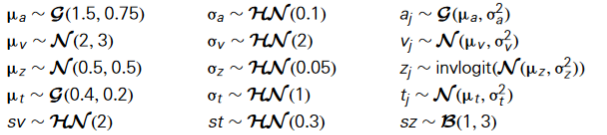


likelihood:
## $behaivior,rt \sim Wiener(v,z,a,t)$


## $v \sim ΒN$


## $behaivior,rt \sim Wiener(ΒN,z,a,t)$

In [ ]:
!apt-get install python3.7

In [ ]:
!apt install python3-pip

In [ ]:
!python3.7 -m pip install scikit-learn
!python3.7 -m pip install cython
!python3.7 -m pip install pymc==2.3.8
!python3.7 -m pip install statsmodels==0.12.0

In [ ]:
!pip install -U --no-deps git+https://github.com/hddm-devs/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

In [ ]:
!python3.7 -m pip install matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import kabuki 
import hddm
import numpy as np
import os
import pickle 
import arviz
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler #*
from kabuki.analyze import gelman_rubin
from glob import glob
from joblib import Parallel,delayed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = hddm.load_csv('/content/drive/MyDrive/data.csv')
data['rt'] = data['rt']+0.2
data['response'] = data['_response']
df = data
df = hddm.utils.flip_errors(df)

In [ ]:
df['cpp_slope'] = StandardScaler().fit_transform(df['cpp_slope'].to_numpy().reshape(-1,1))
df['cpp_amplitude'] = StandardScaler().fit_transform(df['cpp_amplitude'].to_numpy().reshape(-1,1))
df['cpp_peak'] = StandardScaler().fit_transform(df['cpp_peak'].to_numpy().reshape(-1,1))

In [ ]:
def z_link_func(x, data=df):
  return 1 / (1+np.exp(-x.to_frame()))

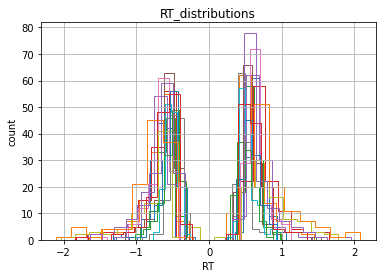

In [ ]:
fig = plt.figure()
ax =fig.add_subplot(111,xlabel='RT',ylabel='count',title = 'RT_distributions')
for i,subj_data in df.groupby('subj_idx'):
  subj_data.rt.hist(bins=20,histtype='step',ax=ax)
  

In [ ]:
os.system('mkdir temp')

256

In [ ]:
def run_m0(id,df=None,samples =None,burn = None,thin=1, save_name =  None):
  dbname = save_name + '_chain_%i.db'%id
  mname = save_name + '_chain_%i'%id
  v_reg = {'model':"v~1+C(coherency,Treatment('low))",'link_func':lambda x:x}
  z_reg = {'model':"z~1+C(prioritization,Treatment('no))",'link_func':z_link_func}
  
  m = hddm.HDDMRegressor(data, [v_reg, z_reg], include=['z'],keep_regressor_trace=True, group_only_regressors=False)
  
  m.find_starting_values()
  m.sample(samples, burn=burn, thin=thin,dbname=dbname,db='pickle')
  m.save(mname)

  return m

In [ ]:
m0 = Parallel(n_jobs=2)(delayed(run_m0)(id = i,df =df,samples=10,burn=1,thin=2,save_name='/content/temp/m0')for i in range(2))

In [ ]:
models_0 = []
for model_path in glob('/content/temp/m0_chain_*'):
  if ('db' not in model_path) and ('csv' not in model_path):
    modelx = hddm.load(model_path)
    models_0.append(modelx)

In [ ]:
print(gelman_rubin(models_0))

{'a': 1.1108496181239107, 'a_std': 1.2996957583933095, 'a_subj.1': 0.8743272716003102, 'a_subj.3': 1.2942468245007601, 'a_subj.5': 1.058370902681188, 'a_subj.6': 0.8816010462326945, 'a_subj.7': 1.2139108049580543, 'a_subj.8': 1.54166562330432, 'a_subj.9': 0.8669423370301319, 'a_subj.10': 0.8706044155774516, 'a_subj.11': 1.6167755543185367, 'a_subj.12': 1.2768188823357889, 'a_subj.13': 0.9341620904808358, 'a_subj.14': 1.4609581331894976, 'a_subj.15': 1.1921560356104408, 'a_subj.16': 0.9050970281327415, 'a_subj.17': 0.8932559275132328, 'v': 0.9830397923283075, 'v_std': 1.1389287216780783, 'v_subj.1': 1.0240296354850413, 'v_subj.3': 0.8830533721174076, 'v_subj.5': 0.8784493281748008, 'v_subj.6': 1.191904462541433, 'v_subj.7': 0.9003150073724814, 'v_subj.8': 0.913769425847248, 'v_subj.9': 1.272190237726661, 'v_subj.10': 1.4521007545573779, 'v_subj.11': 0.8728811675782853, 'v_subj.12': 2.4059906512968174, 'v_subj.13': 1.8901540125090597, 'v_subj.14': 1.4993515922524128, 'v_subj.15': 0.87944

In [ ]:
m0 = kabuki.utils.concat_models(models_0)
m0.plot_posteriors()
m0.plot_posterior_predictive()
print(m0.dic)

In [ ]:
def run_m1(id,df=None,samples =None,burn = None,thin=1, save_name =  None):
  dbname = save_name + '_chain_%i.db'%id
  mname = save_name + '_chain_%i'%id
  v_reg = {'model':"v~1+C(coherency,Treatment('low'))+ cpp_slope + cpp_slope:C(coherency,Treatment('low'))",'link_func':lambda x:x}
  z_reg = {'model':"z~1+C(prioritization,Treatment('no))",'link_func':z_link_func}
  m = hddm.HDDMRegressor(data, [v_reg, z_reg], include=['z'],keep_regressor_trace=True, group_only_regressors=False)
  
  m.find_starting_values()
  m.sample(samples, burn=burn, thin=thin,dbname=dbname,db='pickle')
  m.save(mname)

  return m

In [ ]:
m1 = Parallel(n_jobs=2)(delayed(run_m1)(id = i,df =df,samples=10,burn=1,thin=2,save_name='/content/temp/m1')for i in range(2))

In [ ]:
models_1 = []
for model_path in glob('/content/temp/m0_chain_*'):
  if ('db' not in model_path) and ('csv' not in model_path):
    modelx = hddm.load(model_path)
    models_1.append(modelx)

In [ ]:
print(gelman_rubin(models_1))

In [ ]:
m1 = kabuki.utils.concat_models(models_1)
m1.plot_posteriors()
m1.plot_posterior_predictive()
print(m1.dic)